#### 氧化铁皮——>iron oxide scale;
#### 裂纹系翘皮——>Cracked skin;
#### 精轧周期压痕——>Finish rolling cycle indentation;
#### 保护渣系夹渣——>slag inclusion in mold flux
#### 铁皮灰——>iron gray

### Dataset information

In [1]:
file_path = "./Dataset/Annotation.json"
import json
import os
from collections import Counter
import pandas as pd

with open(file_path,'r') as load_f:
    load_json = json.load(load_f)
#load_json["categories"]
data_path = "./Dataset/Train/"
for name in os.listdir(data_path):
    class_path = data_path+name
    print("{}:{}".format(name,len(os.listdir(class_path))))
anno_class = []
for anno in load_json["annotations"]:
    anno_class.append(anno["category_id"])    
print(Counter(anno_class))

Cracked skin:367
Finish rolling cycle indentation:320
normal:2066
slag inclusion in mold flux:385
iron oxide scale:394
iron gray:357
Counter({5: 576, 1: 567, 4: 430, 3: 375, 2: 364})


### Area and H/w ratio distribution
#### according to coco, small objects are thoes with areas under 1024(32^2), medium objects are those with areas under 9216(64^2),areas of large objects are mainly above 9216
#### above all, in steel defect dataset, there are 542 small objects, 1157 medium objects and 613 large objects 

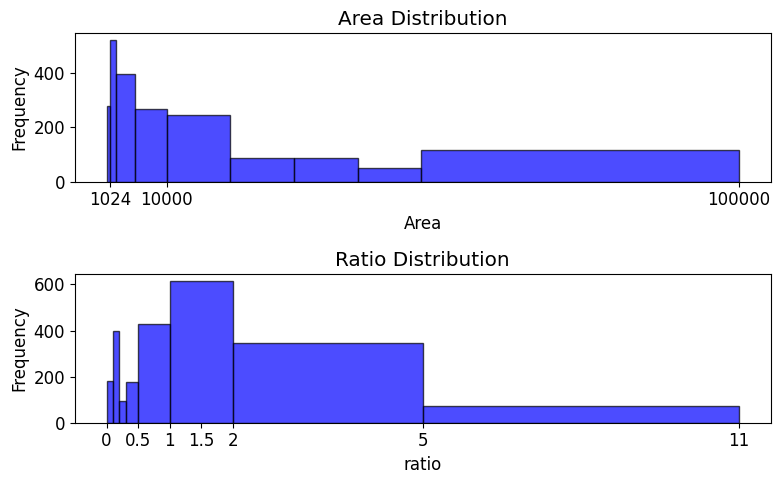

In [65]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 5.0) 
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['figure.dpi'] = 100
plt.figure()
anno_path ="/home/dlsuncheng/Steel_Defect/Dataset/Annotation/Annotation.json"
with open(anno_path,"r") as load_f:
    load_json = json.load(load_f)
area = []
ratio = []
for anno in load_json["annotations"]:
    area.append(round(anno["area"],2))
    ratio.append(round(anno["bbox"][2]/anno["bbox"][3],2))
area.sort()
ratio.sort()
plt.subplot(211)
plt.hist(area, bins=(500,1024,2000,5000,10000,20000,30000,40000,50000,100000),facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xticks((1024,10000,100000),(1024,10000,100000))
plt.xlabel("Area")
# 显示纵轴标签
plt.ylabel("Frequency")
# 显示图标题
plt.title("Area Distribution")
plt.subplot(212)
plt.hist(ratio, bins=(0,0.1,0.2,0.3,0.5,1,2,5,10),facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xticks((0,0.5,1,1.5,2,5,10),(0,0.5,1,1.5,2,5,11))
plt.xlabel("ratio")
plt.ylabel("Frequency")

# 显示图标题
plt.title("Ratio Distribution")
plt.tight_layout()#调整整体空白
# plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
plt.show()


### train-val split

In [1]:
import json
import numpy as np
import copy
np.random.seed(1)
json_path = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation_num.json"
with open(json_path,'r') as load_f:
    load_json = json.load(load_f)
image_num = len(load_json["images"])
image_id_list = [i for i in range(1,image_num+1)]
all_list = dict(train=[],val=[])
np.random.shuffle(image_id_list)
split_point = image_num//5
all_list["val"].extend(image_id_list[:split_point])
all_list["train"].extend(image_id_list[split_point:])

In [38]:
for i in all_list:
    steel_defect_category = [{"id": 1, "name": "iron_oxide", "supercategory": "iron_oxide"}, 
        {"id": 2, "name": "cracked_skin", "supercategory": "cracked_skin"}, 
        {"id": 3, "name": "rolling_cycle", "supercategory": "rolling_cycle"}, 
        {"id": 4, "name": "slag_inclusion", "supercategory": "slag_inclusion"}, 
        {"id": 5, "name": "iron_gray", "supercategory": "iron_gray"}
        ]
    train_dict = {"images": [],
                    "type": "instances",
                    "annotations": [],
                    "categories": steel_defect_category}
    for images in load_json["images"]:
        if images["id"] in all_list[i]:
            train_dict["images"].append(images)
    for anno in load_json["annotations"]:
        if anno["image_id"] in all_list[i]:
            train_dict["annotations"].append(anno)
    with open(i+'_num.json', 'w') as fp:
      json.dump(train_dict, fp)

### check dataloader 

In [17]:
# Copyright (c) OpenMMLab. All rights reserved.

import numpy as np
from mmcv import Config, DictAction
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
cfg_path = "/home/dlsuncheng/Steel_Defect/model/FRCN_Baseline.py"
cfg = Config.fromfile(cfg_path)
cfg.gpu_ids = [1]
dataset = build_dataset(cfg.data.train)
print(dataset)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!

CocoDataset Train dataset with number of images 3112, and instance counts: 
+----------------+-------+------------------+-------+-------------------+-------+--------------------+-------+---------------+-------+
| category       | count | category         | count | category          | count | category           | count | category      | count |
+----------------+-------+------------------+-------+-------------------+-------+--------------------+-------+---------------+-------+
| 0 [iron_oxide] | 447   | 1 [cracked_skin] | 296   | 2 [rolling_cycle] | 288   | 3 [slag_inclusion] | 349   | 4 [iron_gray] | 474   |
|                |       |                  |       |                   |       |                    |       |               |       |
| -1 background  | 1657  |                  |       |                   |       |                    |       |               |       |
+----------------+-------+----

### Image rename

In [15]:
path = "/home/dlsuncheng/Dataset/Steel_Defect/Train_Val_num/"
import os
file_list = os.listdir(path)
file_list.sort()
rename_list = [str(index+1).zfill(6) for index in range(len(file_list))]
for index in range(len(file_list)):
    print(file_list[index],rename_list[index]+file_list[index][-4:])    
    os.rename(path+file_list[index],path+rename_list[index]+file_list[index][-4:])

01262486_11_BF_00032.tif 000001.tif
01263414_12_BF_00015.tif 000002.tif
01263417_04_BF_03057.tif 000003.tif
01263417_04_BF_03077.tif 000004.tif
01263417_04_BF_03322.tif 000005.tif
01263417_05_BF_02996.tif 000006.tif
01263417_05_BF_03043.tif 000007.tif
01263417_05_BF_03049.tif 000008.tif
01263417_05_BF_03086.tif 000009.tif
01263417_06_BF_03162.tif 000010.tif
01263437_13_BF_00798.tif 000011.tif
01263481_05_BF_00256.tif 000012.tif
01263705_02_BF_01942.jpg 000013.jpg
01263705_03_BF_01120.jpg 000014.jpg
01263705_03_BF_01998.jpg 000015.jpg
01263705_04_BF_01084.jpg 000016.jpg
01263705_05_BF_02274.jpg 000017.jpg
01263911_02_BF_00240.jpg 000018.jpg
01263911_02_BF_00243.jpg 000019.jpg
01265391_05_BF_01831.jpg 000020.jpg
01265391_05_BF_01844.jpg 000021.jpg
01268234_03_BF_00346.jpg 000022.jpg
01268234_03_BF_00442.jpg 000023.jpg
01268234_03_BF_00467.jpg 000024.jpg
01268234_03_BF_00487.jpg 000025.jpg
01268234_03_BF_00495.jpg 000026.jpg
01268234_03_BF_00496.jpg 000027.jpg
01268234_03_BF_00498.jpg 000

In [27]:
import json
json_path = "/home/dlsuncheng/Dataset/Steel_Defect/Annotation.json"

with open(json_path,'r') as load_f:
    load_json = json.load(load_f)
for image in load_json["images"]:
    index = file_list.index(image["file_name"])
    image["file_name"]=rename_list[index]+file_list[index][-4:]
with open('Annotation_num.json', 'w') as fp:
    json.dump(load_json, fp)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dlsuncheng/Dataset/Steel_Defect/Annotation.json'

### BBox Visualize

In [28]:
!python /home/dlsuncheng/Steel_Defect/SteelMMdet/tools/analysis_tools/data_visible.py \
    /home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/ \
    /home/dlsuncheng/Steel_Defect/Dataset/Annotation/Annotation_num.json \
    /home/dlsuncheng/Steel_Defect/Dataset/Train_Val_bbox/

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
  0%|                                                  | 0/3889 [00:00<?, ?it/s]/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000876.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001247.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000526.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000485.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001010.jpg
  0%|                                          | 5/3889 [00:00<01:31, 42.51it/s]/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000492.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000978.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000804.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000862.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001044.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000985.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001017.jpg
 

In [26]:
import json
path = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation/Annotation_num.json"
with open(path,"r") as load_f:
    load_json = json.load(load_f)
# [image for image in load_json["images"] if image["file_name"]=="001410.jpg"]
[anno for anno in load_json["annotations"] if anno["image_id"]==1352]

[{'segmentation': [[578.2, 4.0, 584.9, 4.0, 584.9, 127, 578.2, 127]],
  'area': 824.0999999999916,
  'bbox': [578.2, 4.0, 6.699999999999932, 123.0],
  'category_id': 4,
  'id': 1578,
  'image_id': 1352,
  'iscrowd': 0,
  'score': 0.5},
 {'segmentation': [[500.3, 11.0, 514.0, 11.0, 514.0, 124.0, 500.3, 124.0]],
  'area': 1548.0999999999988,
  'bbox': [500.3, 11.0, 13.699999999999989, 113.0],
  'category_id': 4,
  'id': 1579,
  'image_id': 1352,
  'iscrowd': 0,
  'score': 0.5}]

In [25]:
from pycocotools.coco import COCO
ann_file = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation/Annotation_num.json"
coco = COCO(ann_file)
anno_ids = coco.getAnnIds(1352)
print(anno_ids)
# annos = coco.loadAnns(anno_ids)
# print(annos)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
[1578, 1579]


### Convert result to submit format

In [1]:
import json
test_result = "/home/dlsuncheng/Steel_Defect/Submit/FRCN_baseline_test_result.bbox.json"
blank_test = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation/test.json"
result=[]
with open(test_result,'r') as load_f:
    test_json = json.load(load_f)
with open(blank_test,'r') as load_f:
    info_json = json.load(load_f)
for image in test_json:
    index = image["image_id"]
    _,image_name = os.path.split(info_json["images"][index]["file_name"])
    test_image_info = {'name':image_name,'category_id':image["category_id"],'bbox':[round(num,2) for num in image["bbox"]],'score':image["score"]}
    result.append(test_image_info)
with open('./Submit/result.json', 'w') as fp:
    json.dump(result, fp, indent=4, separators=(',', ': '))